In [1]:
# plotting library
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from pandas import CategoricalDtype

# ANOVA library
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy.stats import pearsonr

# cohen's d library
import numpy as np
from itertools import combinations

In [18]:
# data loading
ug_beh = pd.read_csv('../data/LEAP_baseline_ug_n236_analysis.csv')
ug_param = pd.read_csv('../ug_modeling/baseline_fit/UG_fit_FSvarf0_Sep24.csv')

sm_beh = pd.read_csv('../data/LEAP_baseline_rl_n220_analysis.csv')
sm_param = pd.read_csv('../rl_modeling/baseline_fit/RL_fit_RW_valence_T1_May25.csv')

# Ploting functions

In [6]:
# data format and visual standard 
def format(df, task, mod=0):
    if task == 'ug' and mod == 0:
        df['offer'] = df['offer'].astype('int32')

        cat_order = CategoricalDtype(['Healthy','Depression','Anhedonia','Both'], ordered=True)
        df['group']= df['group'].astype(cat_order)
        df.sort_values('group')

        cat_order = CategoricalDtype(['Low','Medium','High'], ordered=True)
        df['offer_bin']= df['offer_bin'].astype(cat_order)
        df = df.sort_values('offer_bin')
    elif task == 'sm' and mod == 0:
        cat_order = CategoricalDtype(['Healthy','Depression','Anhedonia','Both'], ordered=True)
        df['group']= df['group'].astype(cat_order)
        df.sort_values('group')

        cat_order = CategoricalDtype(['numberbar_neg','numberbar_mixed','numberbar_pos'], ordered=True)
        df['block_type']= df['block_type'].astype(cat_order)
        df.sort_values('block_type')

    # Map the 'depression' and 'anhedonia' values to 'high' and 'low'
    df['depression_level'] = pd.Categorical(df['depression'].map({1: 'high', 0: 'low'}), categories=['low', 'high'], ordered=True)
    df['anhedonia_level'] = pd.Categorical(df['anhedonia'].map({1: 'high', 0: 'low'}), categories=['low', 'high'], ordered=True)

    return df

In [45]:
# behavior plotting function
def ug_2x2_plot(df, y_var_label_dict, palette):
    """
    Create a 2x2 level plot with 3 panels using Seaborn.

    Parameters:
    - df: DataFrame containing the data.
    - y_var_label_dict: Dictionary where keys are y-variables and values are y-axis labels.
    - palette: Color palette for the plot (default is 'Set2').
    """
    # Create subplots
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))

    # panel labels
    # panel_labels = ['a', 'b', 'c']

    # Plot each panel
    for i, (y_var, y_label) in enumerate(y_var_label_dict.items()):
        sns.stripplot(data=df, x='depression_level', y=y_var, color='grey', jitter=True, alpha=0.5, size=3, ax=ax[i])
        sns.pointplot(data=df, x='depression_level', y=y_var, hue='anhedonia_level',
            ax=ax[i], errorbar=('se', 1), linestyles="none",
            palette=palette, capsize=.3, dodge=True, legend=False if i < 2 else True)  # Legend only on the last plot
        ax[i].set_ylabel(y_label)
        ax[i].set_xlabel('depression level')
        # add panel label
        # ax[i].text(-0.5, 1.1, panel_labels[i], transform=ax[i].transAxes, fontsize=15, fontweight='bold', va='top')

    # Adjust legend
    plt.legend(title='anhedonia level', bbox_to_anchor=(1.35, 0.5), loc='center', borderaxespad=0, frameon=False)
    plt.tight_layout()
    sns.despine()

    return fig, ax

In [51]:
# behavior plotting function
def sm_2x2_plot(df, y_var, y_label, palette, block_types=None):
    # Set default block types if not provided
    if block_types is None:
        block_types = ['numberbar_neg', 'numberbar_mixed', 'numberbar_pos']
    
    block_names = ['punishment', 'mixed', 'reward']

    # Create subplots
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))

    # panel labels
    # panel_labels = ['a', 'b', 'c']
    # panel_labels = ['d', 'e', 'f']

    for i, block_type in enumerate(block_types):
        if i < 2:
            sns.stripplot(data=df[df['block_type'] == block_type], x='depression_level', y=y_var, color='grey', jitter=True, alpha=0.5, size=3, ax=ax[i])
            sns.pointplot(data=df[df['block_type'] == block_type], x='depression_level', y=y_var, hue='anhedonia_level',
                ax=ax[i], errorbar=('se', 1), linestyles="none",
                palette=palette, capsize=0.3, dodge=False, legend=False)

        else:
            sns.stripplot(data=df[df['block_type'] == block_type], x='depression_level', y=y_var, color='grey', jitter=True, alpha=0.5, size=3, ax=ax[i])
            sns.pointplot(
                data=df[df['block_type'] == block_type], x='depression_level', y=y_var, hue='anhedonia_level',
                ax=ax[i], errorbar=('se', 1), linestyles="none",
                palette=palette, capsize=0.3, dodge=False, legend=True)

        # add panel label
        # ax[i].text(-0.1, 1.1, panel_labels[i], transform=ax[i].transAxes, fontsize=15, fontweight='bold', va='top')
        # ax[i].set_title(block_names[i], pad=20)
        ax[i].set_ylabel(y_label)
        ax[i].set_xlabel('depression level')

    plt.legend(title='anhedonia level', bbox_to_anchor=(1.35, 0.5), loc='center', borderaxespad=0, frameon=False)
    plt.tight_layout()
    sns.despine()

    return fig, ax

In [9]:
# parameter plotting function
def param_violin_2x2_plot(df, y_var_label_dict, palette, panel, split=True, cut=1, linewidth=1.5, fill=False):
    """
    Create a 2x2 level plot with n-panel violin plot using Seaborn.

    Parameters:
    - df: DataFrame containing the data.
    - y_var_label_dict: Dictionary where keys are y-variables and values are y-axis labels.
    - palette: Color palette for the plot (default is 'Set2').
    - split: Whether to split the violin plot by hue (default is True).
    - cut: Distance, in units of bandwidth size, to extend the density past extreme datapoints (default is 1).
    - linewidth: Width of the lines that will be drawn to subdivide the violins (default is 1.5).
    - fill: Whether to fill the violin plot (default is False).
    """
    # Create subplots
    fig, ax = plt.subplots(1, panel, figsize=(15, 5))

    # panel labels
    # panel_labels = ['a', 'b', 'c', 'd']

    # Plot each panel
    for i, (y_var, y_label) in enumerate(y_var_label_dict.items()):
        sns.violinplot(data=df, x='depression_level', y=y_var, hue='anhedonia_level',
            ax=ax[i], split=split, cut=cut,
            linewidth=linewidth, fill=fill, palette=palette, legend=False if i < (panel - 1) else True)
        ax[i].set_ylabel(y_label)
        ax[i].set_xlabel('depression level')
        # ax[i].text(-0.5, 1.1, panel_labels[i], transform=ax[i].transAxes, fontsize=15, fontweight='bold', va='top')

    # Adjust legend
    plt.legend(title='anhedonia level', bbox_to_anchor=(1.35, 0.5), loc='center', borderaxespad=0, frameon=False)
    plt.tight_layout()
    sns.despine()

    return fig, ax

In [10]:
# 2-way ANOVA function 
def two_way_anova_effect_size(df, param):
    """
    Perform 2-way ANOVA and calculate effect size (Partial Eta Squared) for a given parameter.

    Parameters:
    df (pandas.DataFrame): The input dataframe.
    param (str): The dependent variable (parameter of interest) for the ANOVA.

    Returns:
    anova_table (pandas.DataFrame): The ANOVA table with effect size (Partial Eta Squared).
    """
    # Fit the 2-way ANOVA model
    model = ols(f'{param} ~ C(depression) * C(anhedonia)', data=df).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)

    # Calculate Partial Eta Squared (η²_p)
    anova_table['eta_sq'] = anova_table['sum_sq'] / (anova_table['sum_sq'].sum() + anova_table['sum_sq'].values[-1])

    # Print the parameter and return the ANOVA table
    print(f"2-way ANOVA Results for {param}:")
    return anova_table

In [11]:
# cohen's d function
def compute_cohens_d(df, param, group_col='group'):
    """
    Compute Cohen's d effect size for each pair of groups in the dataframe.

    Parameters:
    df (pandas.DataFrame): The input dataframe.
    param (str): The column name of the dependent variable for which to compute Cohen's d.
    group_col (str): The column name of the categorical variable defining the groups.

    Returns:
    None (prints Cohen's d for each pair of groups)
    """
    # Function to compute Cohen's d
    def cohen_d(x, y):
        nx = len(x)
        ny = len(y)
        dof = nx + ny - 2
        pooled_std = np.sqrt(((nx - 1) * np.var(x, ddof=1) + (ny - 1) * np.var(y, ddof=1)) / dof)
        return (np.mean(x) - np.mean(y)) / pooled_std

    # Get unique groups from the specified group column
    groups = df[group_col].unique()

    print(f'Effect size (Cohen\'s d) for {param}:')
    
    # Compute Cohen's d for each pair of groups
    for group1, group2 in combinations(groups, 2):
        data1 = df[df[group_col] == group1][param]
        data2 = df[df[group_col] == group2][param]
        d = cohen_d(data1, data2)
        print(f"Cohen's d between {group1} and {group2}: {d:.4f}")

In [12]:
sns.set(font_scale=1.3, style='white')
sns.set_context('talk')

ug_palette = {
    'low': '#abb9f5',
    "high": '#565d7b'
}
sm_palette = {
    'low': '#f5abb9',
    "high": '#7b565d'
}

# check for shared participants 

In [73]:
# Get unique participant IDs from both dataframes
ug_ids = set(ug_beh['participant'].unique())
rl_ids = set(sm_beh['participant'].unique())

# Find overlapping participants
shared_ids = ug_ids.intersection(rl_ids)

# Optionally convert to list or print
print(f"Number of overlapping participants: {len(shared_ids)}")

Number of overlapping participants: 220


# Regression data prep (archive later)

In [11]:
ug_param_df = ug_param[['participant', 'envy', 'lr', 'f0']]
ug_param_df

,participant,envy,lr,f0
0,559002fefdf99b3f7aada38f,1.179145,0.002464,9.126541
1,5590a34cfdf99b729d4f69dc,4.298776,0.019140,5.388372
2,5596a991fdf99b2d1e834690,1.284121,0.002376,6.105862
3,55a75835fdf99b26395fae40,3.459627,0.027486,6.441936
4,55b237e6fdf99b19ea79d2f7,5.782475,0.003628,5.256966
...,...,...,...,...
156,636168a962acef1f1f1cc4ce,4.818701,0.010352,8.197061
157,63b6cee06aaa9fc9669b8cc2,1.687782,0.000663,12.341007
158,63c34086cb929e7c9b844a67,5.448691,0.006559,8.538700
159,63d15717bf9f5277f27bbe5e,1.142200,0.000801,11.995174


In [12]:
ug_demo = ug_beh.drop_duplicates(subset='participant', keep='first')
ug_reg = pd.merge(ug_param_df, ug_demo, how='left', on='participant')
ug_reg

,participant,envy,lr,f0,Unnamed: 0.1,age,sex,gender,edu_level,ladder_us,...,rating_rt,rating_start,rating,choice_rej,choice_acc,offer_bin,rating_z,rating_delta,rating_fill,log_rt
0,559002fefdf99b3f7aada38f,1.179145,0.002464,9.126541,1440,38,1,1,5,3,...,NaN,50.0,NaN,0.0,1.0,Medium,NaN,NaN,NaN,0.403463
1,5590a34cfdf99b729d4f69dc,4.298776,0.019140,5.388372,9720,57,2,2,5,5,...,NaN,30.0,NaN,0.0,1.0,Medium,NaN,NaN,NaN,1.161744
2,5596a991fdf99b2d1e834690,1.284121,0.002376,6.105862,4980,31,1,1,3,5,...,NaN,50.0,NaN,0.0,1.0,Medium,NaN,NaN,NaN,0.150917
3,55a75835fdf99b26395fae40,3.459627,0.027486,6.441936,4620,32,2,2,3,5,...,NaN,50.0,NaN,1.0,0.0,Medium,NaN,NaN,NaN,0.517781
4,55b237e6fdf99b19ea79d2f7,5.782475,0.003628,5.256966,13080,54,2,2,5,4,...,NaN,48.0,NaN,0.0,1.0,Medium,NaN,NaN,NaN,0.968466
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
156,636168a962acef1f1f1cc4ce,4.818701,0.010352,8.197061,5040,38,2,2,6,7,...,NaN,13.0,NaN,1.0,0.0,Medium,NaN,NaN,NaN,0.343164
157,63b6cee06aaa9fc9669b8cc2,1.687782,0.000663,12.341007,13860,41,2,2,3,3,...,NaN,6.0,NaN,1.0,0.0,Medium,NaN,NaN,NaN,1.077967
158,63c34086cb929e7c9b844a67,5.448691,0.006559,8.538700,9300,40,1,1,5,7,...,NaN,32.0,NaN,1.0,0.0,Medium,NaN,NaN,NaN,0.901989
159,63d15717bf9f5277f27bbe5e,1.142200,0.000801,11.995174,4200,36,2,2,5,4,...,NaN,50.0,NaN,0.0,1.0,Medium,NaN,NaN,NaN,0.785726


In [13]:
# ug_reg.dropna(inplace=True) #double check here why it's needed for slot machine? 
ug_reg.to_csv('../4.online_study_nbs/lme_project/ug_model_lme_data_varf0.csv')

# Ultimatum Game Figure

## UG behavior results

In [24]:
ug_sub

,participant,depression_level,anhedonia_level,log_rt,choice_acc,rating
1,54847f1cfdf99b07b28f22f9,low,high,0.115221,1.000000,25.200000
7,54e32a60fdf99b3eae9de85b,high,high,0.461935,1.000000,23.842105
11,559002fefdf99b3f7aada38f,high,high,0.444697,0.533333,17.200000
14,5590a34cfdf99b729d4f69dc,high,low,0.548300,0.633333,29.880349
16,5596a991fdf99b2d1e834690,low,low,-0.022567,0.733333,43.700000
...,...,...,...,...,...,...
927,63ae31ff5c725a41082afc56,high,high,0.268395,0.525424,24.653063
928,63b6cee06aaa9fc9669b8cc2,low,low,-0.117565,0.150000,39.700000
933,63c34086cb929e7c9b844a67,low,high,-0.174335,0.233333,9.174225
939,63d15717bf9f5277f27bbe5e,high,high,0.268604,0.300000,23.417035


In [23]:
ug_beh = format(ug_beh, 'ug')
ug_sub = ug_beh.groupby(['participant', 'depression_level','anhedonia_level']).mean().reset_index()[['participant','depression_level','anhedonia_level','log_rt', 'choice_acc', 'rating']].dropna()

y_var_label_dict = {
    'log_rt': 'log reaction time (s)',
    'choice_acc': 'acceptance rate',
    'rating': 'mood rating'
}

C:\Users\fuq01\AppData\Local\Temp\ipykernel_13620\2302285046.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ug_sub = ug_beh.groupby(['participant', 'depression_level','anhedonia_level']).mean().reset_index()[['participant','depression_level','anhedonia_level','log_rt', 'choice_acc', 'rating']].dropna()


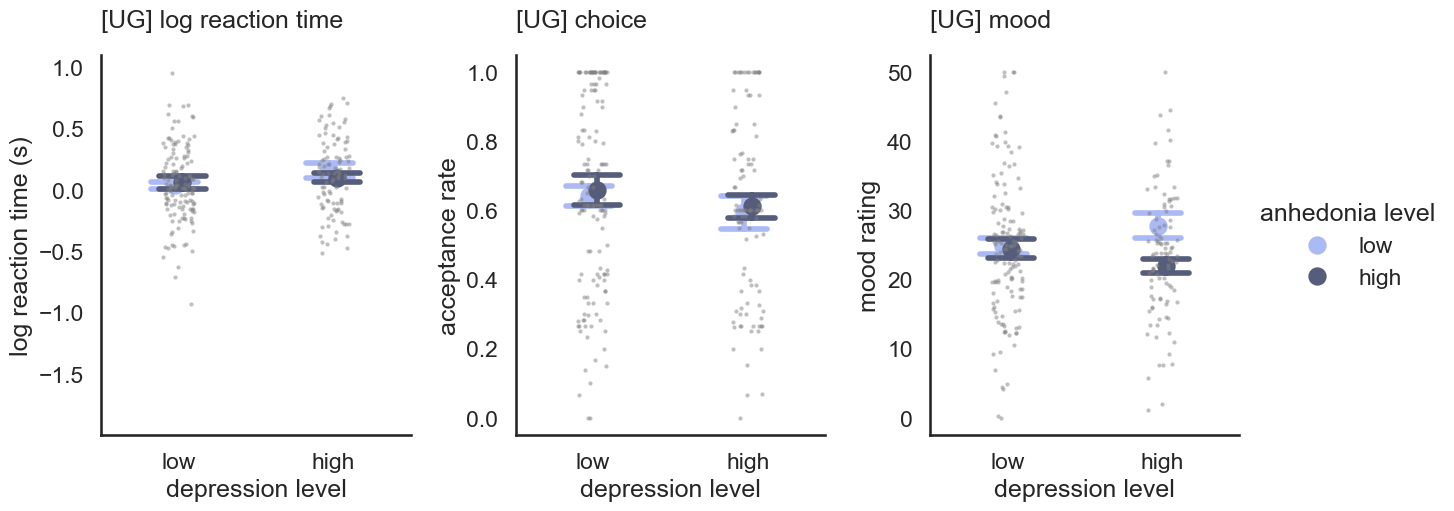

In [70]:
fig, ax = ug_2x2_plot(ug_sub, y_var_label_dict, ug_palette)

# add title
ax[0].set_title('[UG] log reaction time', loc='left', pad=20)
ax[0].set_ylim(-2, 1.1)
ax[0].set_yticks([-1.5, -1.0, -0.5, 0, 0.5, 1])

ax[1].set_title('[UG] choice', loc='left', pad=20)
ax[2].set_title('[UG] mood', loc='left', pad=20)

# save figure
# plt.savefig('./figure/fig2_2.pdf', dpi=300)

# Show the updated plot
plt.show()

## UG model results

In [27]:
# load modeling results
ug_FSfixf0 = pd.read_csv('../UG-EM/1_baseline_fit/UG_fit_FSfixf0_Sep24.csv')
ug_FSvarf0 = pd.read_csv('../UG-EM/1_baseline_fit/UG_fit_FSvarf0_Sep24.csv')
ug_RWfixf0 = pd.read_csv('../UG-EM/1_baseline_fit/UG_fit_RWfixf0_May25.csv')
ug_RWvarf0 = pd.read_csv('../UG-EM/1_baseline_fit/UG_fit_varf0_Sep24.csv')

# concate all models together
ug_all = pd.concat([ug_FSfixf0, ug_FSvarf0, ug_RWfixf0, ug_RWvarf0], axis=0)

In [ ]:
# model labels
model_labels = {
    'FSfixf0': 'FS-fixed-f0',
    'FSvarf0': 'FS-variable-f0',
    'RWfixf0': 'RW-fixed-f0',
    'varf0':   'RW-variable-f0'
}

# replace the model names
ug_all['model'] = ug_all['model'].replace(model_labels)

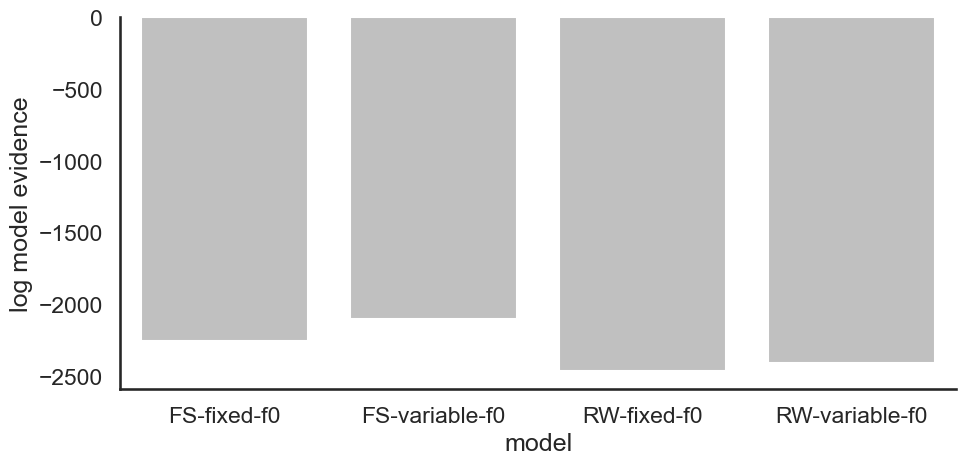

In [29]:
# Get LME per model
lme = ug_all.groupby('model')['LME'].mean().reset_index()

# Plot
plt.figure(figsize=(10, 5))
sns.barplot(x='model', y='LME', data=lme, color='silver')
plt.ylabel('log model evidence')
sns.despine()

# Adjust layout and save full figure
plt.tight_layout()
plt.savefig('./figure/T1_modeling_ug/T1_LME.png', dpi=300)

In [31]:
lme

,model,LME
0,FS-fixed-f0,-2253.979064
1,FS-variable-f0,-2101.038536
2,RW-fixed-f0,-2468.490014
3,RW-variable-f0,-2409.371698


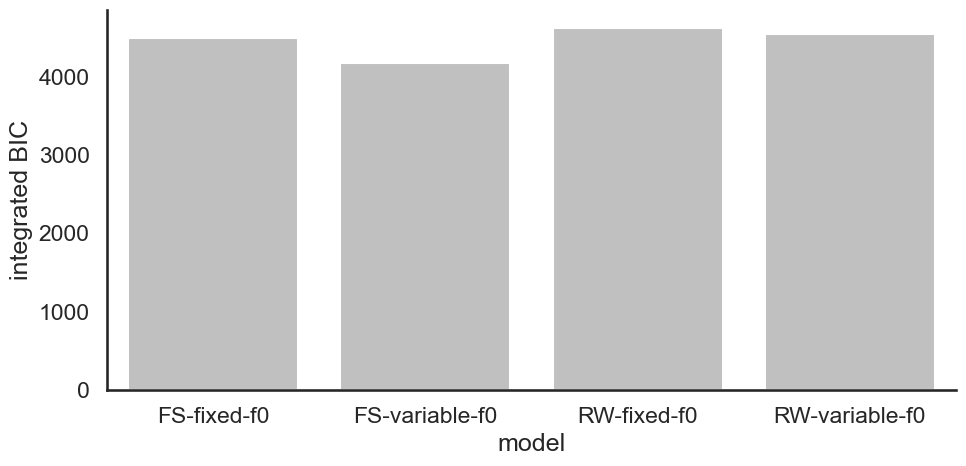

In [32]:
# Get BIC per model
bic = ug_all.groupby('model')['BICint'].mean().reset_index()

# Plot
plt.figure(figsize=(10, 5))
sns.barplot(x='model', y='BICint', data=bic, color='silver')
plt.ylabel('integrated BIC')
sns.despine()

# Adjust layout and save full figure
plt.tight_layout()
plt.savefig('./figure/T1_modeling_ug/T1_intBIC.png', dpi=300)

In [33]:
bic

,model,BICint
0,FS-fixed-f0,4491.682750
1,FS-variable-f0,4173.152379
2,RW-fixed-f0,4618.978569
3,RW-variable-f0,4537.564106


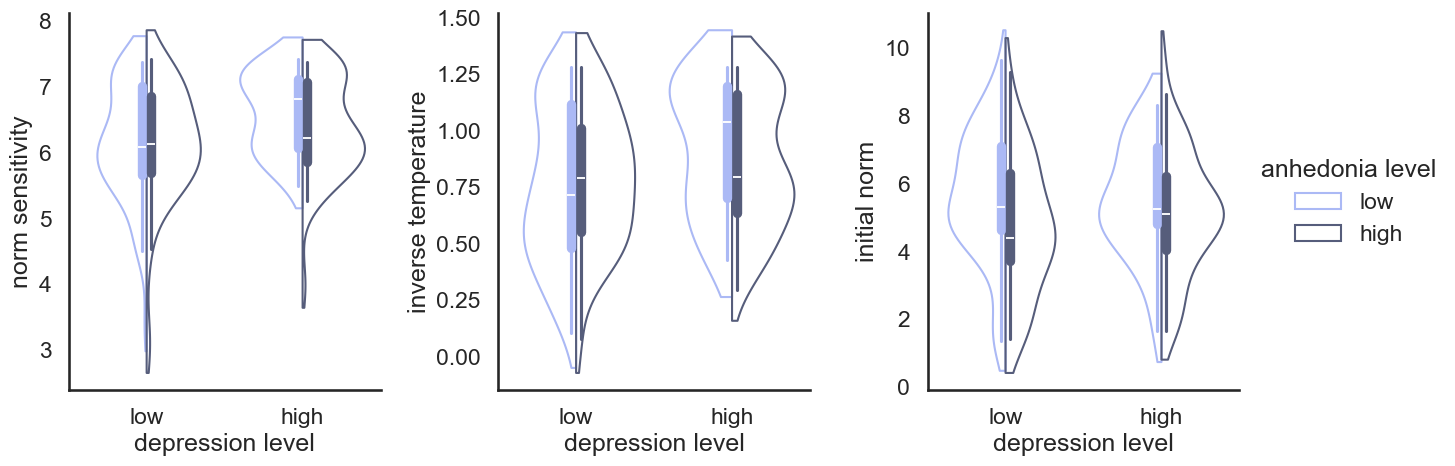

In [34]:
# model fitted plot
ug_fit_dict = {
    'envy': 'norm sensitivity',
    # 'lr': 'norm update rate',
    'beta': 'inverse temperature',
    'f0': 'initial norm'
}

ug_FSvarf0 = format(ug_FSvarf0, 'ug', mod=1)
fig, ax = param_violin_2x2_plot(df=ug_FSvarf0, y_var_label_dict=ug_fit_dict, palette=ug_palette, panel=3)

# # Add a floating significance line to a specific subplot (e.g., subplot 0)
# ax[0].plot([0.1, 0.9], [0.98, 0.98], transform=ax[0].transAxes, color='black', linestyle='-', linewidth=2)
# # Add '*' to indicate significance at the top center above the line
# ax[0].text(0.5, 0.95, '*', transform=ax[0].transAxes, color='black', fontsize=25, verticalalignment='bottom', horizontalalignment='center', fontweight='bold')

# save figure
# plt.savefig('./figure/fig3.pdf', dpi=300)

In [35]:
ug_FSvarf0['participant'].nunique()

161

In [36]:
# all effect size for loop
for param in ug_fit_dict.keys():
    compute_cohens_d(ug_FSvarf0, param)

Effect size (Cohen's d) for envy:
Cohen's d between Both and Depression: -0.3671
Cohen's d between Both and Healthy: 0.2679
Cohen's d between Both and Anhedonia: 0.2908
Cohen's d between Depression and Healthy: 0.5809
Cohen's d between Depression and Anhedonia: 0.6217
Cohen's d between Healthy and Anhedonia: 0.0137
Effect size (Cohen's d) for beta:
Cohen's d between Both and Depression: -0.2625
Cohen's d between Both and Healthy: 0.3245
Cohen's d between Both and Anhedonia: 0.2148
Cohen's d between Depression and Healthy: 0.5469
Cohen's d between Depression and Anhedonia: 0.4725
Cohen's d between Healthy and Anhedonia: -0.1242
Effect size (Cohen's d) for f0:
Cohen's d between Both and Depression: -0.2228
Cohen's d between Both and Healthy: -0.2715
Cohen's d between Both and Anhedonia: 0.1996
Cohen's d between Depression and Healthy: -0.0604
Cohen's d between Depression and Anhedonia: 0.4116
Cohen's d between Healthy and Anhedonia: 0.4539


## UG model regression data

In [37]:
ug_param_df = ug_FSvarf0[['participant', 'envy', 'beta', 'f0']]
ug_param_df.head()

,participant,envy,beta,f0
0,559002fefdf99b3f7aada38f,5.775241,0.536156,5.618185
1,5590a34cfdf99b729d4f69dc,6.891640,1.089102,4.809381
2,5596a991fdf99b2d1e834690,5.704733,0.603408,4.017737
3,55a75835fdf99b26395fae40,6.639446,0.968213,5.112232
4,55b237e6fdf99b19ea79d2f7,7.377922,1.281289,5.068228


In [38]:
# load dataframe for psychiatric labels 
baseline_demo = pd.read_csv('../4.online_study_nbs/data/LEAP_n236_demographics.csv')
ug_reg = pd.merge(ug_param_df, baseline_demo, how='left', on='participant')
ug_reg.head(), ug_reg['participant'].nunique()

(                participant      envy      beta        f0  age  sex  gender  \
 0  559002fefdf99b3f7aada38f  5.775241  0.536156  5.618185   38    1       1   
 1  5590a34cfdf99b729d4f69dc  6.891640  1.089102  4.809381   57    2       2   
 2  5596a991fdf99b2d1e834690  5.704733  0.603408  4.017737   31    1       1   
 3  55a75835fdf99b26395fae40  6.639446  0.968213  5.112232   32    2       2   
 4  55b237e6fdf99b19ea79d2f7  7.377922  1.281289  5.068228   54    2       2   
 
    edu_level  ladder_us  queer  ... total_prior_diag  md_anx_prior_diag  \
 0          5          3      0  ...                2                  2   
 1          5          5      0  ...                0                  0   
 2          3          5      0  ...                0                  0   
 3          3          5      0  ...                3                  3   
 4          5          4      0  ...                4                  3   
 
   non_md_prior_diag  bdi_total  pvss_total  apathy_score  a

In [39]:
ug_reg.to_csv('../4.online_study_nbs/lme_project/ug_T1_model_lme_data_FSvarf0.csv')

## UG model comparision (old)

In [ ]:
ug_fixf0b = pd.read_csv('./em_results/UG_fit_fixf0b_Sep24.csv') # testing model
ug_fixf0b_norm = pd.read_csv('./em_results/UG_fit_fixf0b_UG_fixf0b_normed_Sep24.csv') #testing model
ug_varf0b = pd.read_csv('./em_results/UG_fit_varf0_Sep24.csv') #RW-varf0  

# concat two model df vertically
ug_all = pd.concat([ug_fixf0b, ug_fixf0b_norm, ug_varf0b], axis=0)

C:\Users\fuq01\AppData\Local\Temp\ipykernel_34732\3693122420.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='model', y='LME', data=lme, palette='Set2')


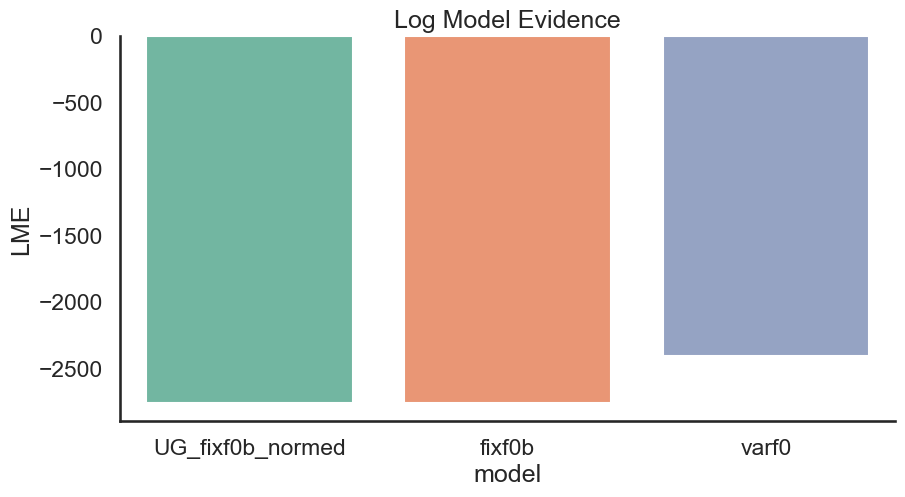

In [20]:
# get bic sum per model
lme = ug_all.groupby('model')['LME'].mean().reset_index()
plt.figure(figsize=(10, 5))
sns.barplot(x='model', y='LME', data=lme, palette='Set2')
# plt.ylim(-9000, -9700)
plt.title('Log Model Evidence')

sns.despine()

C:\Users\fuq01\AppData\Local\Temp\ipykernel_34732\357902684.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='model', y='BICint', data=lme, palette='Set2')


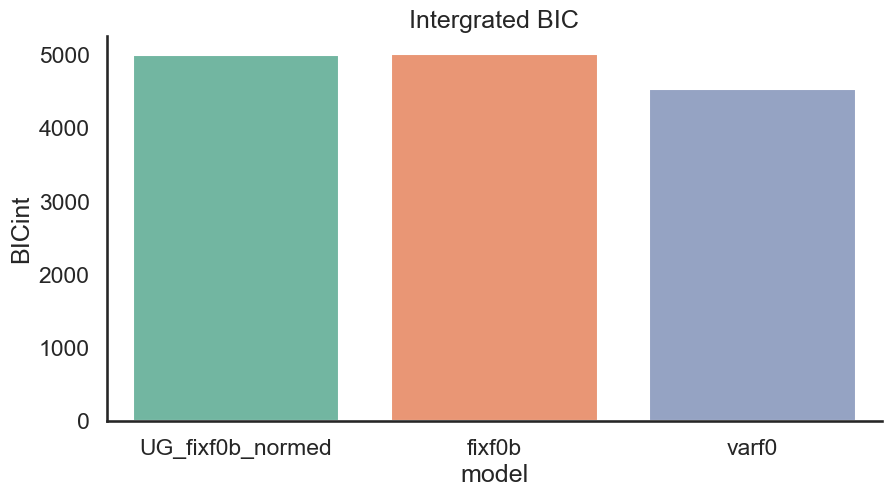

In [21]:
# get bic sum per model
lme = ug_all.groupby('model')['BICint'].mean().reset_index()
plt.figure(figsize=(10, 5))
sns.barplot(x='model', y='BICint', data=lme, palette='Set2')
# plt.ylim(16000, 20000)
plt.title('Intergrated BIC')

sns.despine()

## Parameter recovery

In [22]:
ug_sim_fixf0b = pd.read_csv('../UG-EM/sim_data/simulated_sim_fixf0b.csv')
ug_sim_fixf0_norm = pd.read_csv('../UG-EM/sim_data/simulated_sim_fixf0_normed.csv')
ug_sim_varf0b = pd.read_csv('../UG-EM/sim_data/simulated_sim_varf0.csv')


In [23]:
# make above plotting as function taking param_names and dataframe as inpute
def plot_param_recovery(param_names, df, mod):
    sns.set_context('talk')
    fig, ax = plt.subplots(1, 4, figsize=(15, 5))
    # Panel labels (a, b, c, d)
    panel_labels = ['a', 'b', 'c', 'd']
    for idx, param in enumerate(param_names):
        sns.scatterplot(data=df, x=f'{param}_sim', y=param, ax=ax[idx], color='grey', alpha=0.5)
        sns.regplot(data=df, x=f'{param}_sim', y=param, ax=ax[idx], color='black', scatter=False, ci=95)
        r, _ = pearsonr(df[param], df[f'{param}_sim'])
        ax[idx].text(0.05, 0.95, f'Pearson r = {r:.2f}', transform=ax[idx].transAxes, fontsize=12, verticalalignment='top')
        ax[idx].set_xlabel('simulated')
        ax[idx].set_ylabel('estimated')
        ax[idx].set_title(param)

        # Add panel label (e.g., a, b, c, d)
        ax[idx].text(-0.1, 1.15, panel_labels[idx], transform=ax[idx].transAxes, fontsize=16, fontweight='bold', va='top', ha='right')

    # add model name as title
    fig.suptitle(mod)
    sns.despine()
    plt.tight_layout()
    plt.show()

In [24]:
mod = 'fixf0_norm'

if mod == 'fixf0b':
    param_names = ['envy', 'lr'] 
    recov_df    = ug_sim_fixf0b
elif mod == 'fixf0_norm':
    param_names = ['envy', 'lr', 'beta'] 
    recov_df    = ug_sim_fixf0_norm
elif mod == 'varf0b':
    param_names = ['envy', 'lr', 'f0'] 
    recov_df    = ug_sim_varf0b

In [25]:
# take the first row per subject
recov_df = recov_df.groupby('subject').first().reset_index()
recov_df.head()

,subject,block,trial,choices,choices_A,rewards,offers,norms,choice_nll,vd,envy,lr,beta,ev_a,ev_r,envy_sim,lr_sim,beta_sim,model
0,0,0,0,A,1.0,6.0,6.0,0.5,0.016033,2.542199,2.163316,0.600405,1.622641,6.0,-12.158011,2.830887,0.649592,1.855843,sim_fixf0_normed
1,1,0,0,R,0.0,0.0,3.0,0.5,0.000004,-8.316607,2.650160,0.389977,1.504525,3.0,-6.987127,3.699936,0.394246,1.834716,sim_fixf0_normed
2,2,0,0,R,0.0,0.0,1.0,0.5,-0.000000,-35.282729,6.269088,0.356938,1.120003,1.0,-4.141497,6.585009,0.277609,1.847396,sim_fixf0_normed
3,3,0,0,R,0.0,0.0,7.0,0.5,0.477375,-0.885470,7.338619,0.641828,0.554832,7.0,-48.407544,6.808078,0.573243,1.800284,sim_fixf0_normed
4,4,0,0,A,1.0,9.0,9.0,0.5,0.000022,8.182284,5.786910,0.858696,1.312310,9.0,-49.437191,2.888452,0.826535,1.789591,sim_fixf0_normed


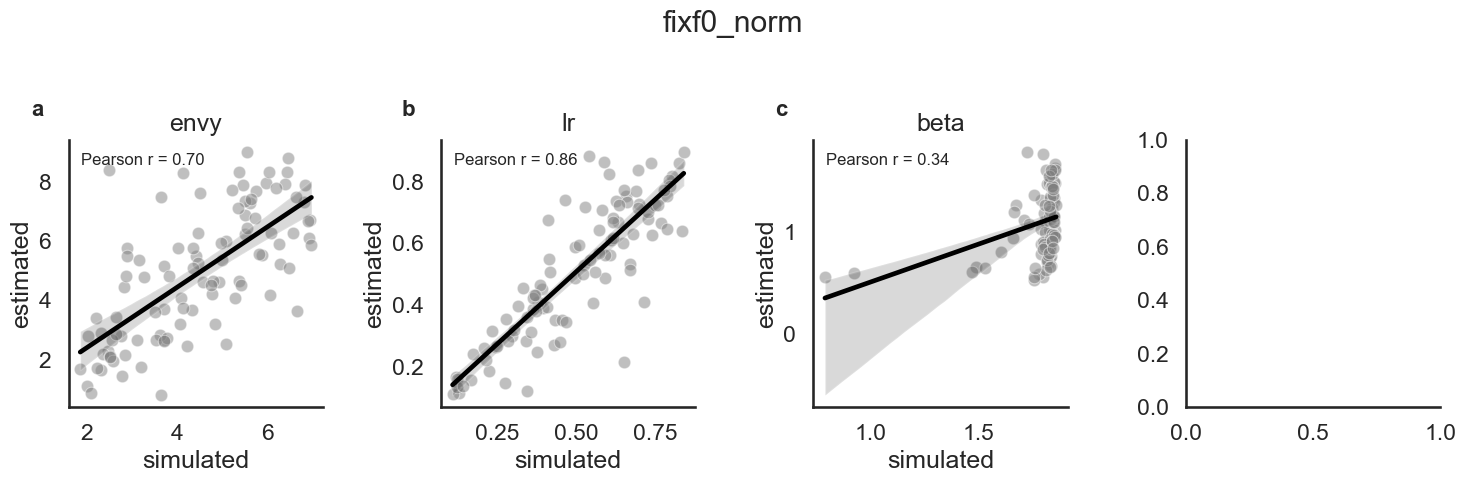

In [26]:
plot_param_recovery(param_names, recov_df, mod)

# Reversal Learning Figure

## RL behavior results

In [37]:
sm_beh = format(sm_beh, 'sm')
sm_sub = sm_beh.groupby(['participant', 'depression_level','anhedonia_level','block_type']).mean().reset_index()[['participant','depression_level','anhedonia_level','block_type', 'log_rt', 'optimal']].dropna()

C:\Users\fuq01\AppData\Local\Temp\ipykernel_13620\1029290225.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  sm_sub = sm_beh.groupby(['participant', 'depression_level','anhedonia_level','block_type']).mean().reset_index()[['participant','depression_level','anhedonia_level','block_type', 'log_rt', 'optimal']].dropna()


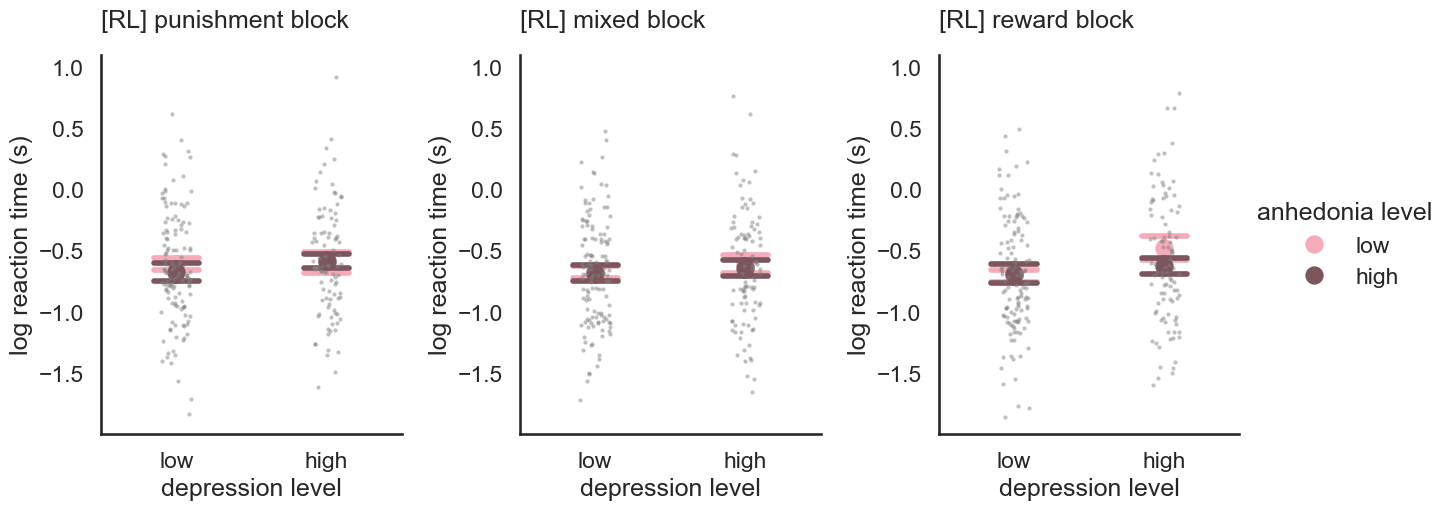

In [68]:
fig, ax = sm_2x2_plot(sm_sub, 'log_rt', 'log reaction time (s)', sm_palette)

# add title
ax[0].set_title('[RL] punishment block', loc='left', pad=20)
ax[0].set_ylim(-2, 1.1)
ax[0].set_yticks([-1.5, -1.0, -0.5, 0, 0.5, 1])

ax[1].set_title('[RL] mixed block', loc='left', pad=20)
ax[1].set_ylim(-2, 1.1)
ax[1].set_yticks([-1.5, -1.0, -0.5, 0, 0.5, 1])

ax[2].set_title('[RL] reward block', loc='left', pad=20)
ax[2].set_ylim(-2, 1.1)
ax[2].set_yticks([-1.5, -1.0, -0.5, 0, 0.5, 1])

# save figure
# plt.savefig('./figure/fig4_1_2.pdf', dpi=300)

(0.0, 1.0)

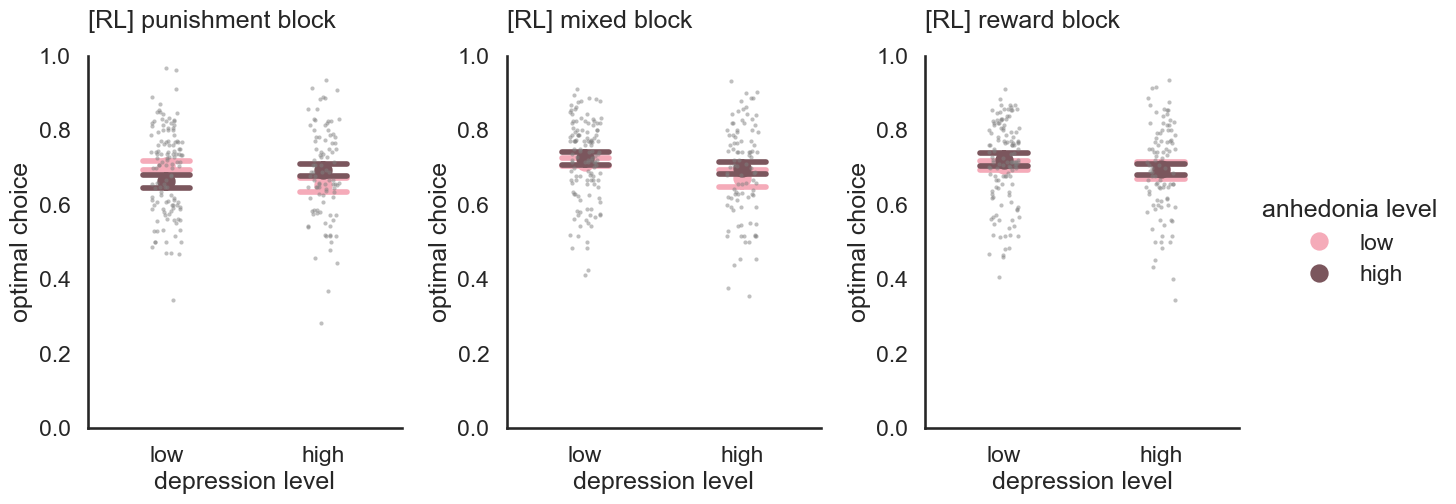

In [65]:
fig, ax = sm_2x2_plot(sm_sub, 'optimal', 'optimal choice', sm_palette)

# add title
ax[0].set_title('[RL] punishment block', loc='left', pad=20)
ax[0].set_ylim(0, 1)
ax[1].set_title('[RL] mixed block', loc='left', pad=20)
ax[1].set_ylim(0, 1)
ax[2].set_title('[RL] reward block', loc='left', pad=20)
ax[2].set_ylim(0, 1)

# save figure
# plt.savefig('./figure/fig4_2_2.pdf', dpi=300)

## RL model results

In [12]:
# load modeling results
rl_basic = pd.read_csv('../RL-EM/1_baseline_fit/RL_fit_RW_basic_T1_May25.csv')
rl_valence = pd.read_csv('../RL-EM/1_baseline_fit/RL_fit_RW_valence_T1_May25.csv')
rl_outcome = pd.read_csv('../RL-EM/1_baseline_fit/RL_fit_RW_outcome_T1_May25.csv')
rl_context = pd.read_csv('../RL-EM/1_baseline_fit/RL_fit_RW_context_T1_May25.csv')

# concate all models together
rl_all = pd.concat([rl_basic, rl_valence, rl_outcome, rl_context], axis=0)

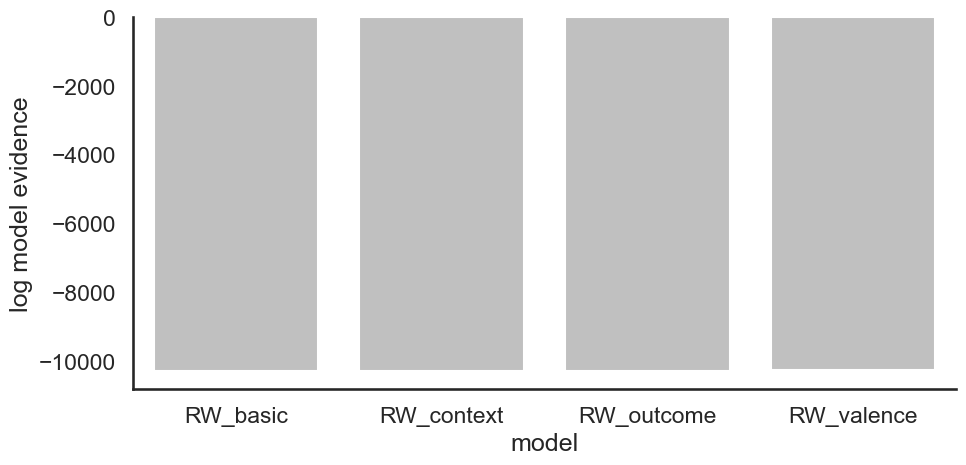

In [20]:
# Get LME per model
lme = rl_all.groupby('model')['LME'].mean().reset_index()

# Plot
plt.figure(figsize=(10, 5))
sns.barplot(x='model', y='LME', data=lme, color='silver')
plt.ylabel('log model evidence')
sns.despine()

# Adjust layout and save full figure
plt.tight_layout()
plt.savefig('./figure/T1_modeling_rl/T1_LME.png', dpi=300)

In [21]:
lme

,model,LME
0,RW_basic,-10288.591862
1,RW_context,-10309.537323
2,RW_outcome,-10300.945592
3,RW_valence,-10284.527418


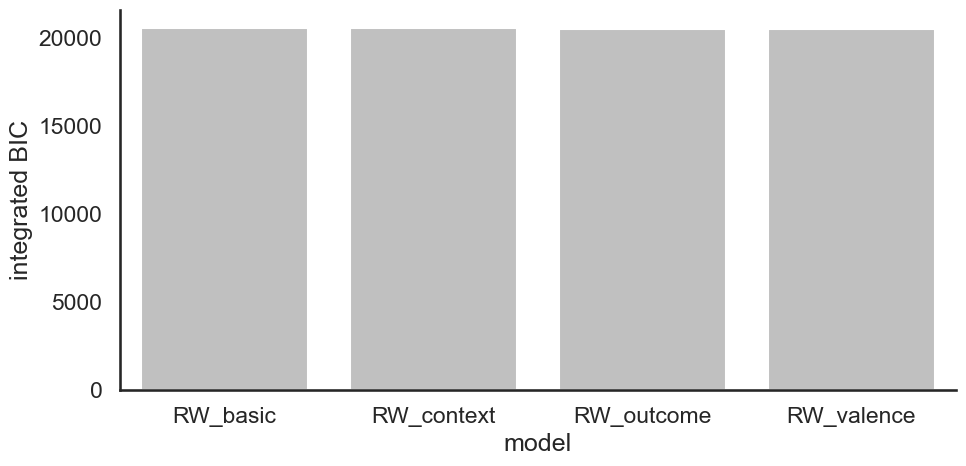

In [22]:
# Get BIC per model
bic = rl_all.groupby('model')['BICint'].mean().reset_index()

# Plot
plt.figure(figsize=(10, 5))
sns.barplot(x='model', y='BICint', data=bic, color='silver')
plt.ylabel('integrated BIC')
sns.despine()

# Adjust layout and save full figure
plt.tight_layout()
plt.savefig('./figure/T1_modeling_rl/T1_intBIC.png', dpi=300)

In [23]:
bic

,model,BICint
0,RW_basic,20575.244044
1,RW_context,20572.834996
2,RW_outcome,20546.929530
3,RW_valence,20545.256360


In [17]:
rl_valence

,alpha_pos,alpha_neg,beta,participant,bic,model,BICint,LME,depression,anhedonia,group,depression_level,anhedonia_level
0,0.746135,0.907689,1.098490,559002fefdf99b3f7aada38f,135.082311,RW_valence,20545.25636,-10284.527418,1,1,Both,high,high
1,0.981994,0.822245,1.098491,5590a34cfdf99b729d4f69dc,101.096419,RW_valence,20545.25636,-10284.527418,1,0,Depression,high,low
2,0.973001,0.910453,1.098491,5596a991fdf99b2d1e834690,107.606972,RW_valence,20545.25636,-10284.527418,0,0,Healthy,low,low
3,0.980355,0.932738,1.098491,55a75835fdf99b26395fae40,93.409045,RW_valence,20545.25636,-10284.527418,1,1,Both,high,high
4,0.978824,0.931003,1.098491,55b237e6fdf99b19ea79d2f7,102.096573,RW_valence,20545.25636,-10284.527418,1,1,Both,high,high
...,...,...,...,...,...,...,...,...,...,...,...,...,...
202,0.979190,0.895129,1.098491,63a9e5cb1dd0a02fffe7b8b4,109.395504,RW_valence,20545.25636,-10284.527418,1,1,Both,high,high
203,0.980020,0.928136,1.098490,63ae31ff5c725a41082afc56,119.470350,RW_valence,20545.25636,-10284.527418,1,1,Both,high,high
204,0.561107,0.913442,1.098490,63c34086cb929e7c9b844a67,137.588203,RW_valence,20545.25636,-10284.527418,0,1,Anhedonia,low,high
205,0.975975,0.736672,1.098490,63d15717bf9f5277f27bbe5e,122.198179,RW_valence,20545.25636,-10284.527418,1,1,Both,high,high


sm_fit_dict = {
    'alpha_pes': 'loss-block learning rate',
    'alpha_mix': 'mix-block learning rate',
    'alpha_opt': 'win-block learning rate',
    'beta': 'inverse temperature'
}

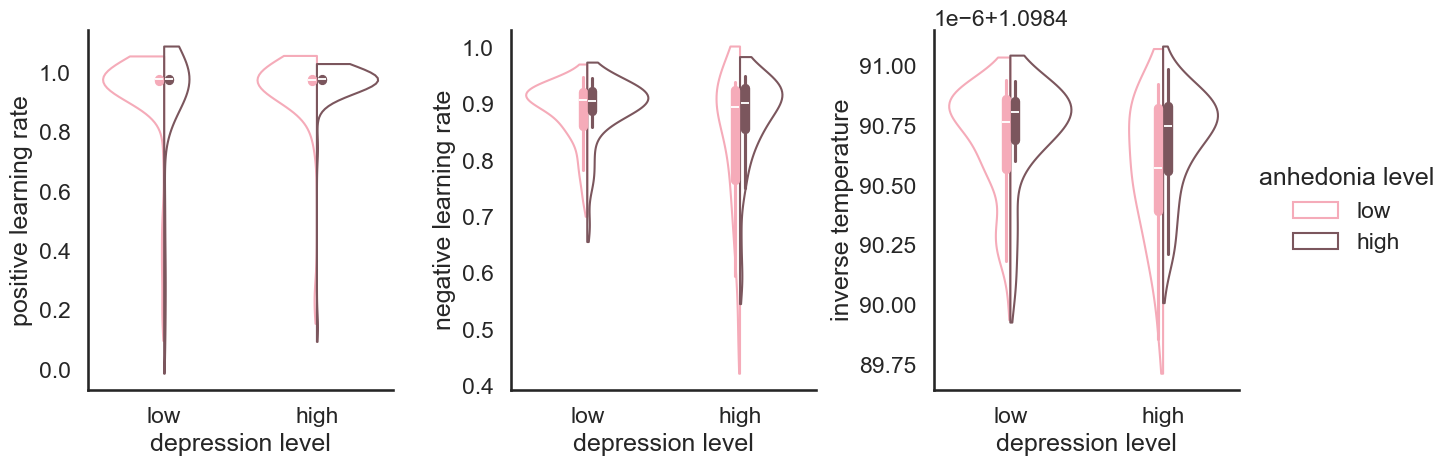

In [24]:
sm_fit_dict = {
    'alpha_pos': 'positive learning rate',
    'alpha_neg': 'negative learning rate',
    # 'alpha_opt': 'win-block learning rate',
    'beta': 'inverse temperature'
}

rl_valence = format(rl_valence, 'sm', mod=1)
# Call the function
param_violin_2x2_plot(df=rl_valence, y_var_label_dict=sm_fit_dict, palette=sm_palette, panel=3)

# save figure
plt.savefig('./figure/T1_modeling_rl/T1_valence_win.png', dpi=300)

In [27]:
rl_valence['participant'].nunique()

207

In [28]:
# all effect size for loop
for param in sm_fit_dict.keys():
    compute_cohens_d(rl_valence, param)

Effect size (Cohen's d) for alpha_pos:
Cohen's d between Both and Depression: 0.1698
Cohen's d between Both and Healthy: 0.2307
Cohen's d between Both and Anhedonia: 0.3453
Cohen's d between Depression and Healthy: 0.0827
Cohen's d between Depression and Anhedonia: 0.1772
Cohen's d between Healthy and Anhedonia: 0.1047
Effect size (Cohen's d) for alpha_neg:
Cohen's d between Both and Depression: 0.4356
Cohen's d between Both and Healthy: -0.1550
Cohen's d between Both and Anhedonia: -0.1830
Cohen's d between Depression and Healthy: -0.6663
Cohen's d between Depression and Anhedonia: -0.5944
Cohen's d between Healthy and Anhedonia: -0.0546
Effect size (Cohen's d) for beta:
Cohen's d between Both and Depression: 0.4804
Cohen's d between Both and Healthy: -0.0535
Cohen's d between Both and Anhedonia: -0.2110
Cohen's d between Depression and Healthy: -0.5242
Cohen's d between Depression and Anhedonia: -0.6383
Cohen's d between Healthy and Anhedonia: -0.1531
